Question a): 
C(x) = R(x) - lambda * Risk(x)
R(x) = Sum_i(u_i * x_i) = Sum_i(u_i * (0.5 - 0.5*Z_i)) = 0.5 * Sum_i(u_i) - 0.5 * Sum_i(u_i * Z_i)
Risk(x) = Sum_i(Sum_j(sigma_ij * x_i * x_j))
using x_i*x_j = 0.25(1 - Z_i - Z_j + Z_i*Z_j), Risk(x) = 0.25 * Sum_i(Sum_j(sigma_ij * (1 - Z_i - Z_j + Z_i*Z_j)))
Risk(x) = 0.25 * (Sum_i(Sum_j(sigma_ij)) - Sum_i(Sum_j(sigma_ij * Z_i)) - Sum_i(Sum_j(sigma_ij * Z_j)) + Sum_i(Sum_j(sigma_ij * Z_i * Z_j)))
H_Cost = 0.5 * (Sum_i(u_i) - Sum_i(u_i * Z_i)) - 0.25lambda * (Sum_i(Sum_j(sigma_ij)) - Sum_i(Sum_j(sigma_ij * Z_i)) - Sum_i(Sum_j(sigma_ij * Z_j)) + Sum_i(Sum_j(sigma_ij * Z_i * Z_j)))

Question b)

In [94]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt

In [422]:
N = 4 # 4 assets to assess in portfolio
sigma = np.array([[1, 0.1, 0.1, 0.1], [0.1, 1, 0.1, 0.1], [0.1, 0.1, 1, 0.1], [0.1, 0.1, 0.1, 0.1]]) # Risks associated with assets
mu = [1, 1, 1, 0.5] # Returns associated with assets
lambda1 = 2 # Risk aversion factor

Q = [[0 for x in range(N)] for y in range(N)] # Not changed from lab

for i in range(N):
    Q[i][i] = -0.5 * mu[i] + lambda1 * 0.25 * sigma[i][i] # Linear terms, changed for this problem

for i in range(N):
    for j in range(N):
        if i != j:
            Q[i][j] += -lambda1 * 0.25 * sigma[i][j] # Quadratic covariance risks, changed for this problem

for k in range(N):
    for kp in range(k + 1, N):
        Q[k][k] = Q[k][k] + (Q[k][kp] + Q[kp][k]) / 2 # Not changed from lab

coeffs = []
for i in range(plen):
    coeffs.append(-Q[i][i] / 2) # Not changed from lab

for i in range(plen):
    for j in range(i + 1, plen):
        coeffs.append((Q[i][j] + Q[j][i]) / 4) # Not changed from lab

lpoptHC = []  # Cost Hamiltonian operators
for i in range(N):
    lpoptHC.append(qml.PauliZ(i)) # Not changed from lab

for i in range(N):
    for j in range(i + 1, N):
        lpoptHC.append(qml.PauliZ(i) @ qml.PauliZ(j)) # Not changed from lab

H_Cost = qml.Hamiltonian(coeffs, lpoptHC)
H_Cost


(
    0.07500000000000001 * Z(0)
  + 0.05 * Z(1)
  + 0.025 * Z(2)
  + 0.1 * Z(3)
  + -0.025 * (Z(0) @ Z(1))
  + -0.025 * (Z(0) @ Z(2))
  + -0.025 * (Z(0) @ Z(3))
  + -0.025 * (Z(1) @ Z(2))
  + -0.025 * (Z(1) @ Z(3))
  + -0.025 * (Z(2) @ Z(3))
)

Question c)

In [425]:
lpoptHM=[]# For the mixer Hamiltonian
coeffsHM=[1]*N
for i in range(N):
    lpoptHM.append(qml.PauliX(i))
print(coeffsHM)
print(lpoptHM)

[1, 1, 1, 1]
[X(0), X(1), X(2), X(3)]


In [427]:
mixer_h=qml.Hamiltonian(coeffsHM,lpoptHM)

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, H_Cost)
    qaoa.mixer_layer(alpha, mixer_h)

wires = range(N)
depth = 10

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("lightning.qubit", wires=wires)

In [429]:
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(H_Cost)

optimizer = qml.AdagradOptimizer()
steps = 180
params = np.array([[0.1]*depth, [0.7]*depth], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(cost_function(params))


print("Optimal Parameters")
print(params)

C:\Users\giles\anaconda3\Lib\site-packages\pennylane\devices\preprocess.py:284: UserWarning: Differentiating with respect to the input parameters of LinearCombination is not supported with the adjoint differentiation method. Gradients are computed only with regards to the trainable parameters of the circuit.

 Mark the parameters of the measured observables as non-trainable to silence this warning.
  warnings.warn(


0.0011946696906545776
-0.0008003167830705656
-0.002425566061718936
-0.003837415686943863
-0.005109189672093395
-0.006284337499764512
-0.007393251641207171
-0.008457773062786188
-0.009490673861001876
-0.01049633828081573
-0.011474249430873433
-0.01242250317835275
-0.013339742718371909
-0.014225747030169444
-0.0150813154406654
-0.01590791757939266
-0.01670735797565999
-0.017481544750673338
-0.01823236021181942
-0.018961598946918776
-0.019670942059294996
-0.020361948850351915
-0.021036056864577296
-0.021694586157759148
-0.022338745807920897
-0.022969641609245
-0.02358828431061454
-0.024195597974702214
-0.024792428156322807
-0.025379549680281385
-0.025957673862229556
-0.026527455070534556
-0.027089496575450664
-0.027644355673614927
-0.028192548110206564
-0.02873455184767307
-0.029270810249072896
-0.029801734756519677
-0.03032770715168573
-0.030849081486355505
-0.03136618576704849
-0.03187932346917462
-0.03238877494378639
-0.03289479876490718
-0.03339763304920247
-0.03389749676418359
-0.034

In [431]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

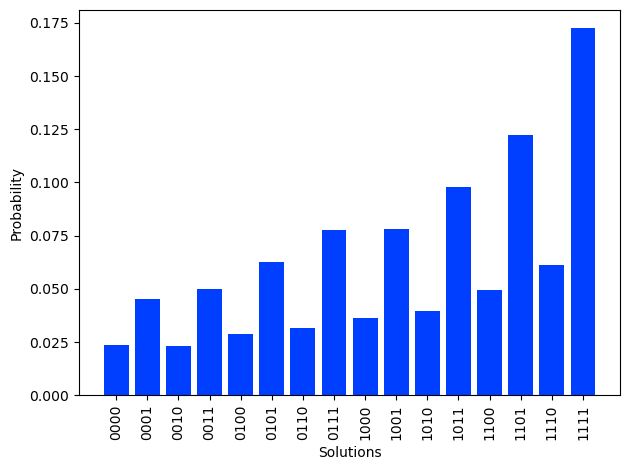

In [433]:
import matplotlib.pyplot as plt

num_qubits = len(wires)
binary_labels = [format(i, f'0{num_qubits}b') for i in range(2 ** num_qubits)]

plt.style.use("seaborn-v0_8-bright")
plt.bar(range(2 ** num_qubits), probs)
plt.xticks(range(2 ** num_qubits), binary_labels, rotation=90) 
plt.xlabel("Solutions")
plt.ylabel("Probability")
plt.tight_layout()  
plt.show()


Question c) i) 


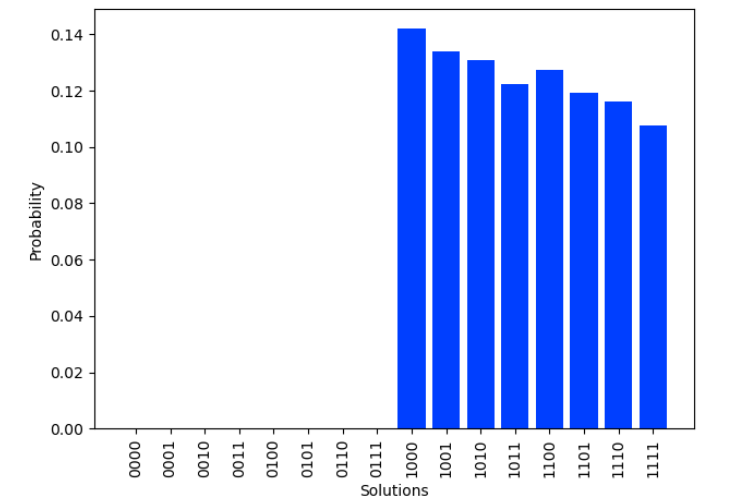


This graph is seen when returns is equal to [10, 1, 1, 1], so investing in asset one has a much higher rate of return. This causes found solutions to all include the first asset, due to its relatively large return.

Question c) ii)

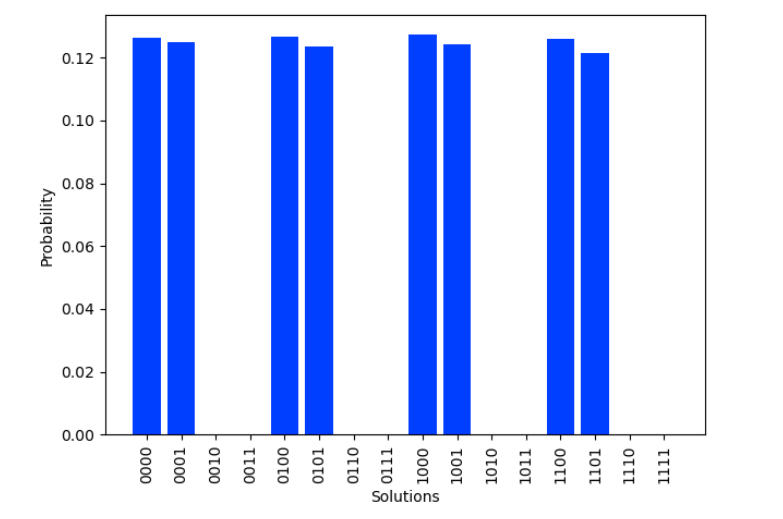


This graph is seen when setting the risk of asset 3 very high, but leaving other assets and correlations between assests at risk 1 (sigma = np.array([[1, 0.1, 0.1, 0.1], [0.1, 1, 0.1, 0.1], [0.1, 0.1, 100, 0.1], [0.1, 0.1, 0.1, 1]])). The graph shows how asset 3 is not included in any optimal solutions due to its high risk. Solutions without asset 3 are all approximately equally optimal.

Question c) iii)

Situation 1


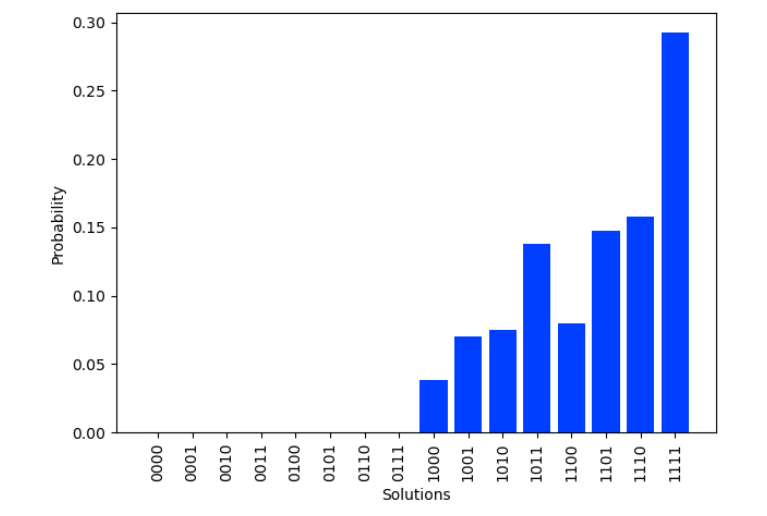


The first plot shows asset 1 having a risk and return of 5, and all other assets having a lower risk and return, with a risk aversion constant of 1. The graph shows that despite the large risk asset 1 has, the algorithm chooses to include the asset due to its high return and the systems low risk aversion.



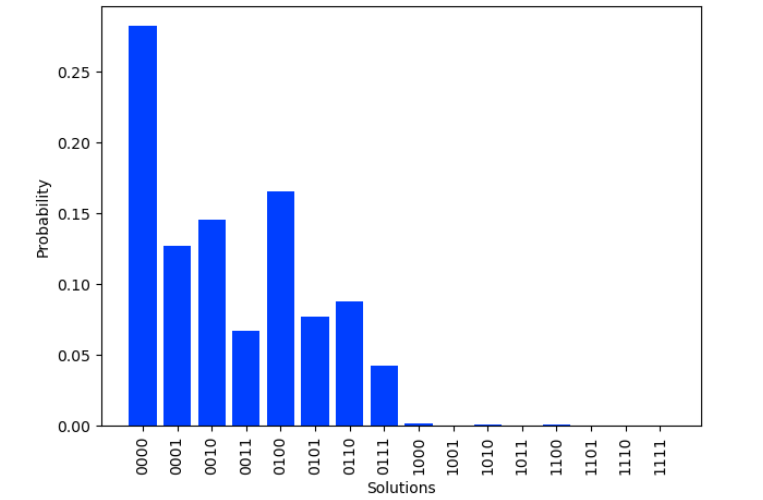   
The second plot shows the same risk/return parameters, but with the risk aversion constant increased to 5. This makes the optimiser leave asset 1 out of the portfolio due to its hightened aversion of risk, and the asset 1 risk of 5 is too high to be ignored by the high risk aversion.

Question c) iii) Situation 2

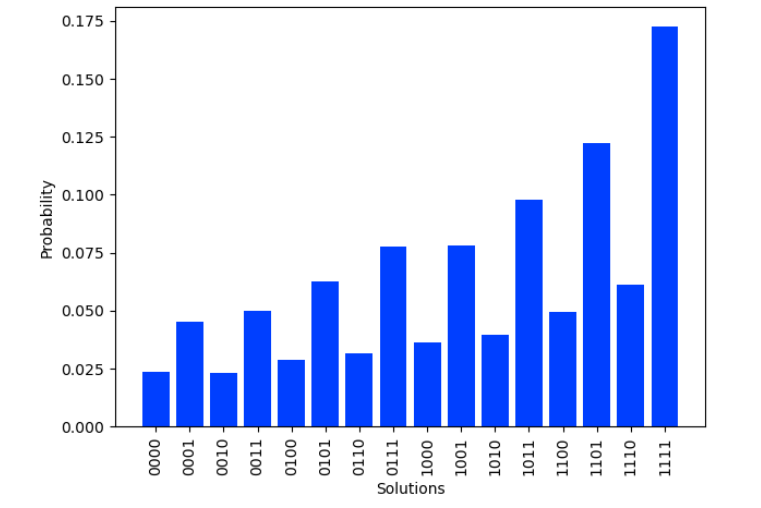

By setting the return of asset 4 to 0.1, with all others having return of 1, but decreasing risk of asset 4 to 0.1, with all others having risk of 1, and setting risk aversion to 2, this plot is produced. It can be seen that the optimal solutions all include asset 4, despite its lower return. This is due to the combination of its lower risk and the systems increased aversion to risk. Some solutions do include asset 4, however, but their probabilities are smaller, and increasing the risk aversion constant would likely make these solutions even less probable

Question d) By introducing a slack variable, S, we can introduce a penalty into our optimisation problem to ensure our portfolio follows the sector exposure constrains. By setting the penalty P = lambda * (x_k,i - M_k + S)^2, the slack variable will change to make P = 0 when x_k,i is less than M_k and follows the constraints. If x_k,i exceeds the M_k constraint, a penalty will be incurred on the cost function and the solution causing this penalty will be avoided by the optimiser. The magnitude of penalty incurred by the violation of constraint will depend upon how much x_k,i has exceeded M_k, and the degree to which the optimiser avoides these solutions with penalties will depend upon the value of lambda. As the optimiser will always try to minimise the cost function, any solution that incurs a penatly and therefore increases the cost function will be avoided if lambda has the appropriate value. As the size of the penalty increases quadratically with S, each further increase of x_k,i to break the constraint will cause a non-linear increase in penalty cost.